# Deep Learning

# Utilizing Apache Spark and PySpark for Deep Learning in Neuroimaging Studies

## Why Spark?

- **Efficient Large Data Handling:**
   - Spark is designed for fast computation and handling big datasets, essential for neuroimaging data.

- **PySpark - Python Integration:**
   - PySpark provides a Python interface to Spark, making it easier to implement deep learning algorithms using Python libraries.

- **Distributed Computing:**
   - Spark's distributed nature allows for parallel processing, speeding up the deep learning tasks.

- **MLlib for Machine Learning:**
   - Spark's MLlib offers machine learning algorithms optimized for big data, which we can leverage for our deep learning models.

## Advantages:

- Spark handles our complex and large participant data efficiently.
- PySpark allows seamless integration with Python's deep learning libraries.
- Distributed processing capability accelerates our deep learning computations.
- Scalability ensures that our system can grow with our data needs.

In summary, Apache Spark and PySpark provide a robust, scalable, and efficient platform for deep learning in our neuroimaging study, enabling us to process large datasets with speed and ease.


## 1 - Setting up Spark cluster

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("PySpark_VSCode").getOrCreate()


In [5]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns



In [6]:
combined_df = pd.read_csv('/home/skander/combined.csv')

In [7]:

# Set 'participant_id' as index
combined_df_with_index = combined_df.set_index('participant_id')

# Extract features for pattern discovery
features = combined_df_with_index  # All columns except 'participant_id'

# Now features DataFrame is ready for unsupervised learning techniques



## 2 - Deep learning

#### A - Base model

We use both CPU and GPU acceleration in order to make the learning process quick. We will use autoencoders as they are particularly effective for dimensionality reduction, feature learning, and anomaly detection. In the context of complex neuroscience data, which often involves high-dimensional datasets, autoencoders can help uncover hidden structures within the data, compress information, and potentially reveal insights that are not immediately apparent with traditional analysis methods.

In [8]:
# Adjust the input dimension to match the number of features in the dataset, here we have one feature with all our numbers
input_dim = features.shape[1]  # Number of features

# Increase the size of the encoded representations to allow the model to capture more complex patterns
encoding_dim = 128  # Adjusted to increase model capacity

# Input layer
input_layer = Input(shape=(input_dim,))

# Enhanced Encoded layer - where the data is compressed
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.5)(encoded)
# Additional encoding layers for more complexity
encoded = Dense(encoding_dim // 2, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.4)(encoded)
encoded = Dense(encoding_dim // 4, activation='relu')(encoded)

# Enhanced Decoded layer - reconstruction of the input
decoded = Dense(encoding_dim // 4, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.4)(decoded)
decoded = Dense(encoding_dim // 2, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Enhanced Autoencoder model
autoencoder = Model(input_layer, decoded)

# Compile the model with the Adam optimizer and mean squared error loss
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping and reduce learning rate on plateau for better training control
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=0.0001)

# Split the data into training and validation sets for model training and evaluation
from sklearn.model_selection import train_test_split
X_train, X_val, _, _ = train_test_split(features, features, test_size=0.2, random_state=42)

# Train the enhanced autoencoder
autoencoder.fit(X_train, X_train,  # Input and output are the same for an autoencoder
                epochs=200,          # Number of epochs
                batch_size=256,     # Batch size
                shuffle=True,       # Shuffle the data
                validation_data=(X_val, X_val),  # Validation data
                callbacks=[early_stopping, reduce_lr])  # Callbacks for monitoring

2024-02-23 16:55:46.449743: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-23 16:55:46.557691: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-23 16:55:46.559045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/200


2024-02-23 16:55:48.231219: I external/local_xla/xla/service/service.cc:168] XLA service 0x7feb50774d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-23 16:55:48.231236: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-02-23 16:55:48.239451: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-23 16:55:48.260905: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1708703748.303451   17859 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 2s 2s/step - loss: 0.2383 - val_loss: 0.1756 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - 0s 21ms/step - loss: 0.2417 - val_loss: 0.1752 - lr: 0.0010
Epoch 3/200
1/1 [==============================] - 0s 18ms/step - loss: 0.2356 - val_loss: 0.1749 - lr: 0.0010
Epoch 4/200
1/1 [==============================] - 0s 19ms/step - loss: 0.2376 - val_loss: 0.1746 - lr: 0.0010
Epoch 5/200
1/1 [==============================] - 0s 18ms/step - loss: 0.2409 - val_loss: 0.1742 - lr: 0.0010
Epoch 6/200
1/1 [==============================] - 0s 21ms/step - loss: 0.2325 - val_loss: 0.1739 - lr: 0.0010
Epoch 7/200
1/1 [==============================] - 0s 18ms/step - loss: 0.2318 - val_loss: 0.1735 - lr: 0.0010
Epoch 8/200
1/1 [==============================] - 0s 17ms/step - loss: 0.2437 - val_loss: 0.1731 - lr: 0.0010
Epoch 9/200
1/1 [==============================] - 0s 18ms/step - loss: 0.2282 - val_loss: 0.1728 - lr: 0.0010
Epoch 10/200
1/

#### B - Determining the optimal number of clusters K in K-means clustering (lol I failed yet I found another path to success)

##### Elbow Method

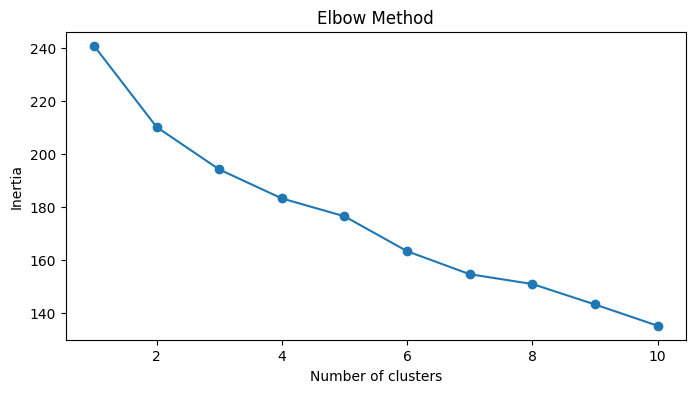

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
for n_clusters in range(1, 11):  # Adjust the range based on your dataset
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


##### Silouhette Analysis

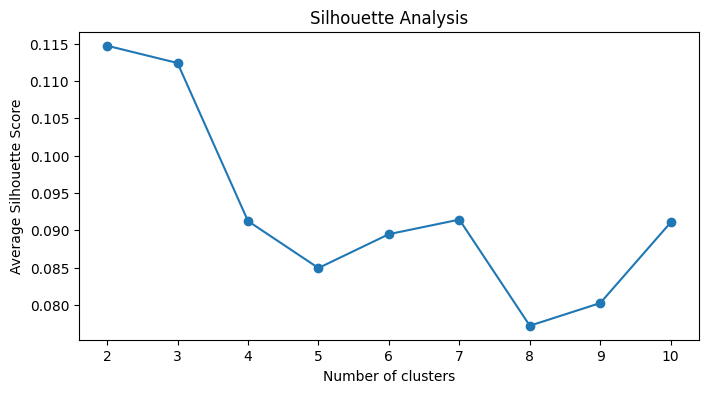

In [10]:
silhouette_avg = []
for n_clusters in range(2, 11):  # Needs at least 2 clusters to define silhouette score
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(features)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(features, cluster_labels))

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_avg, marker='o')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.show()


##### Davies-bouldin index

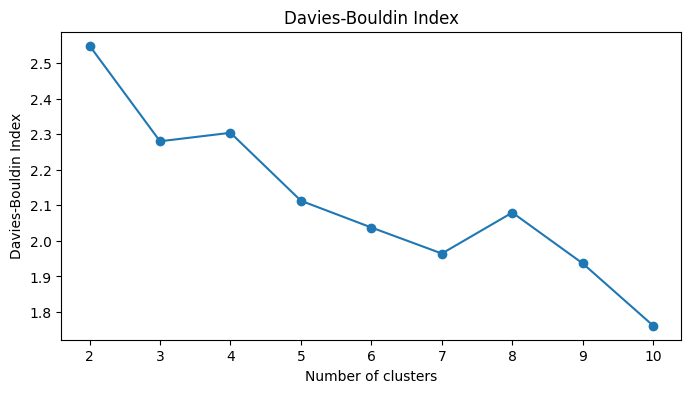

In [11]:
db_index = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(features)
    cluster_labels = kmeans.labels_
    db_index.append(davies_bouldin_score(features, cluster_labels))

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), db_index, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()


#### Conclusion, K-means (which assumes spherical clusters of relatively equal size) isn't the best fit for the inherent structure of the data

#### C - DBScan

In [12]:
# It's often a good idea to standardize data for density based clustering
features_scaled = StandardScaler().fit_transform(features)

# Apply DBSCAN
dbscan = DBSCAN(eps=4.8, min_samples=2).fit(features_scaled)

# Get the cluster labels (note: -1 indicates outliers)
labels = dbscan.labels_

# Number of clusters, excluding noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

# Optionally, you can perform a silhouette analysis to evaluate the quality of the clustering
from sklearn.metrics import silhouette_score
if n_clusters_ > 1:  # silhouette_score requires more than one cluster
    silhouette = silhouette_score(features_scaled, labels)
    print(f"Silhouette Score: {silhouette}")
else:
    print("Silhouette Score cannot be calculated for a single cluster.")

Estimated number of clusters: 6
Estimated number of noise points: 41
Silhouette Score: -0.07306141075534735


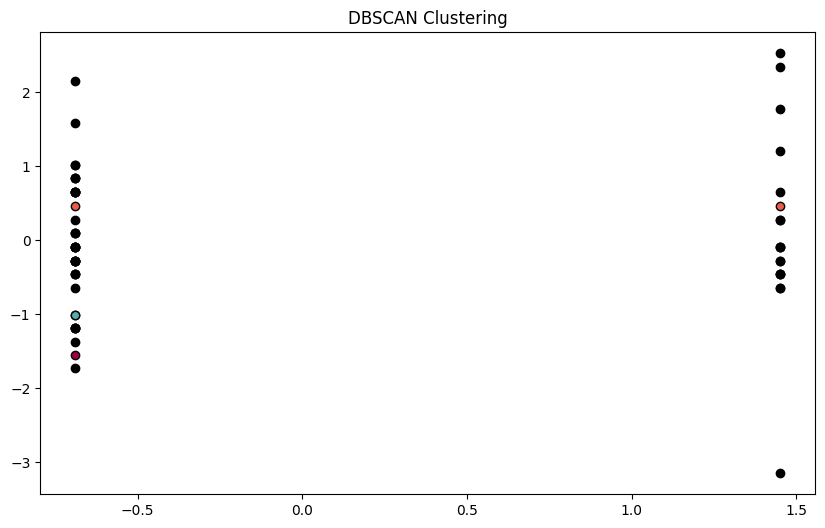

In [13]:
# Assuming features_scaled is two-dimensional for visualization
plt.figure(figsize=(10, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = features_scaled[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('DBSCAN Clustering')
plt.show()

In [14]:
# Assuming 'features' is your original DataFrame and 'labels' is the array of cluster labels from DBSCAN
features['cluster'] = labels

# Calculate the mean for each cluster
cluster_means = features.groupby('cluster').mean()

# Calculate the median for each cluster
cluster_medians = features.groupby('cluster').median()

# Calculate the standard deviation for each cluster
cluster_std_dev = features.groupby('cluster').std()

# Print out the statistics
print("Cluster Means:\n", cluster_means)
print("\nCluster Medians:\n", cluster_medians)
print("\nCluster Standard Deviations:\n", cluster_std_dev)


Cluster Means:
          screen_meds_pastmonth  Inhibited  Self_esteem  \
cluster                                                  
-1                    0.317073   0.584122     0.440390   
 0                    0.000000   0.506800     0.376000   
 1                    0.666667   0.582000     0.538667   
 2                    0.333333   0.441667     0.540000   
 3                    0.666667   0.495333     0.700333   
 4                    0.500000   0.489500     0.684500   
 5                    0.000000   0.361000     0.333500   

         Sensitivity_to_punishment_reward  total_drug_use  \
cluster                                                     
-1                               0.485073         0.02439   
 0                               0.600200         0.00000   
 1                               0.436000         0.00000   
 2                               0.256667         0.00000   
 3                               0.538667         0.00000   
 4                               0

In [15]:
# Separate noise from clustered data
noise_data = features[features['cluster'] == -1]
clustered_data = features[features['cluster'] != -1]

# You can then perform statistical analysis on both, or just on clustered_data


##### First attempt to clusterize each column

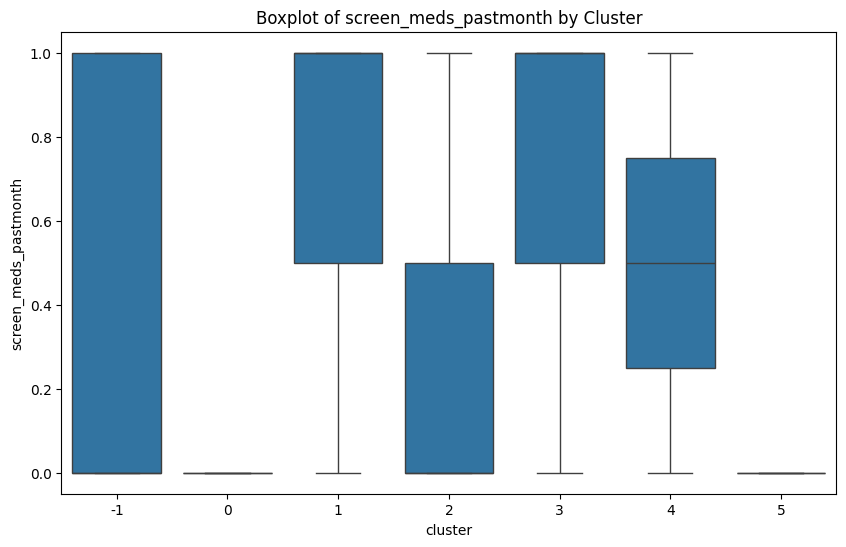

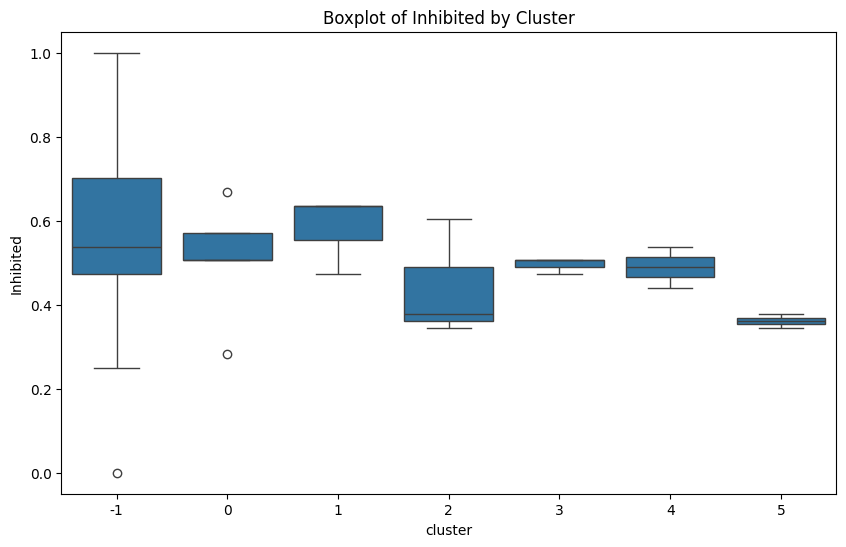

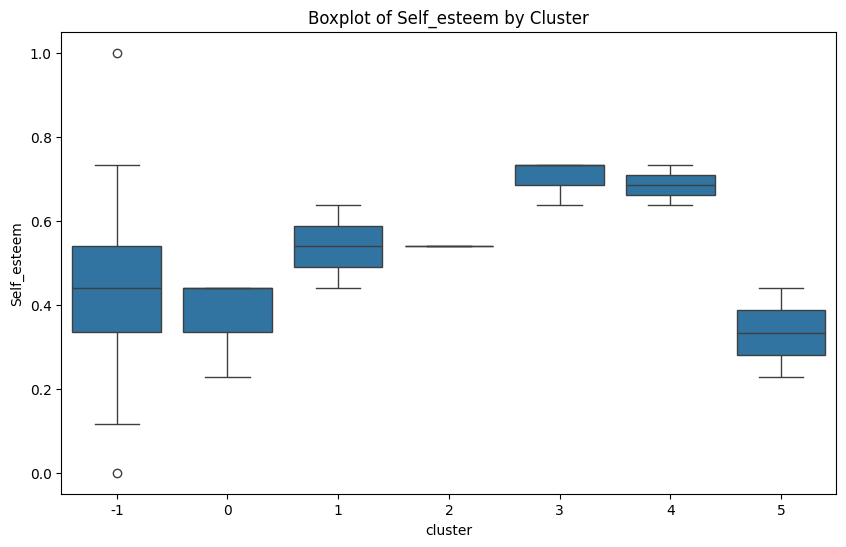

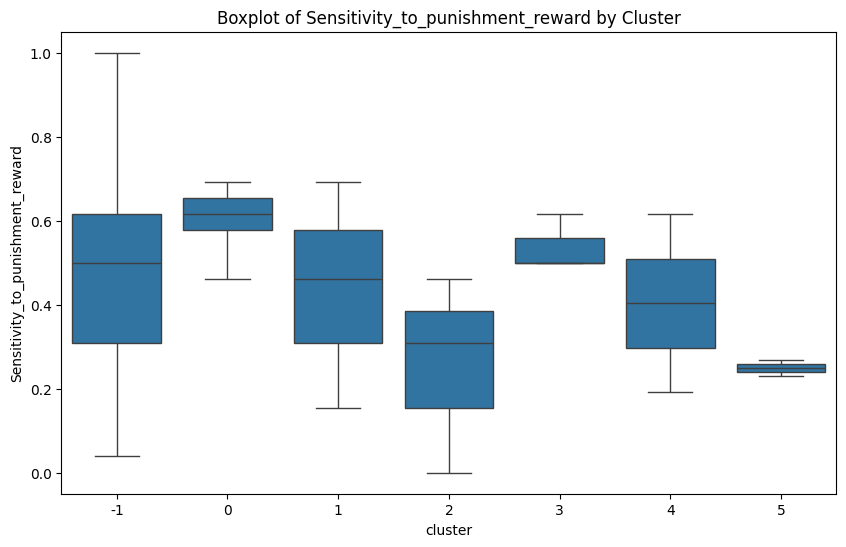

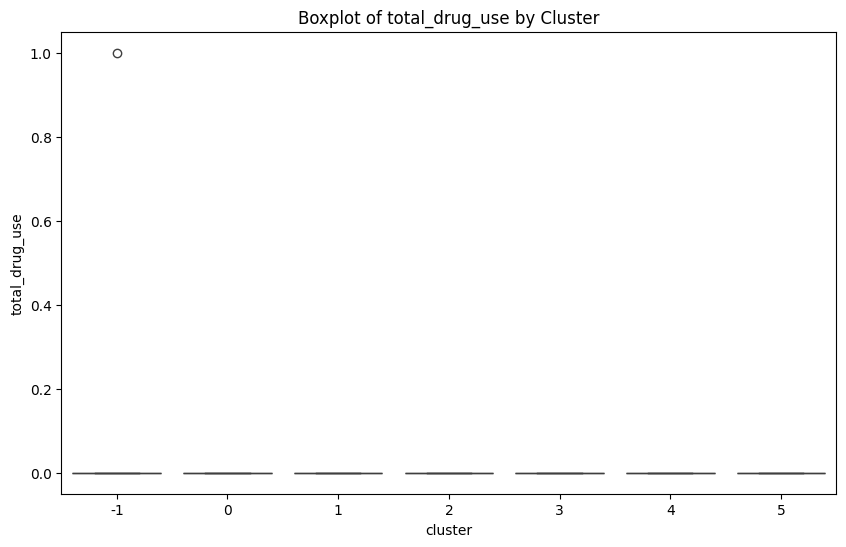

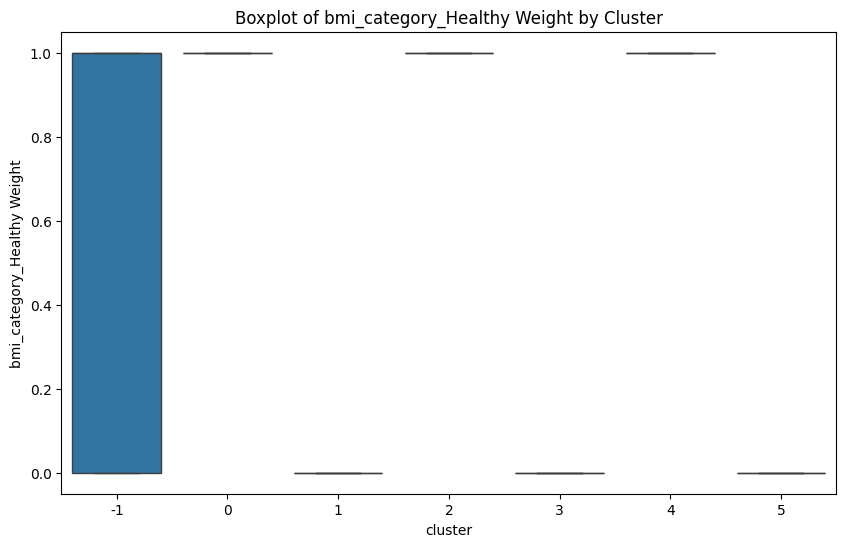

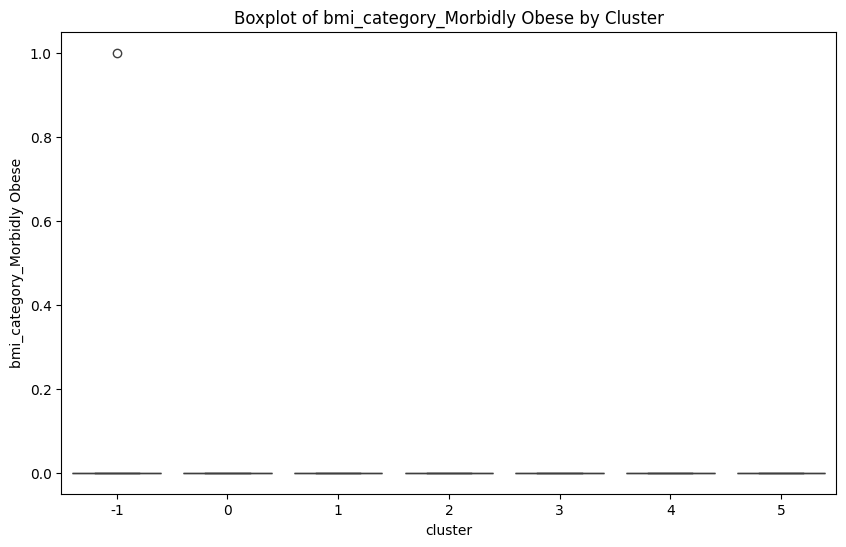

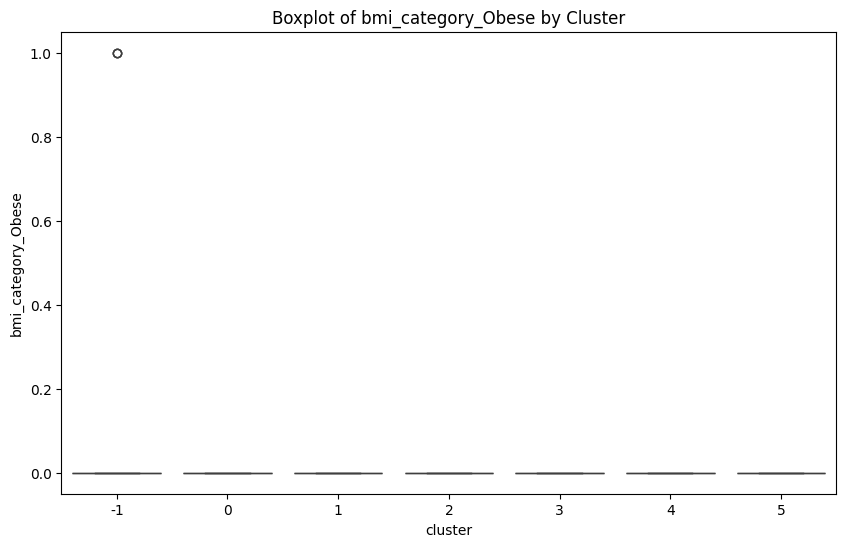

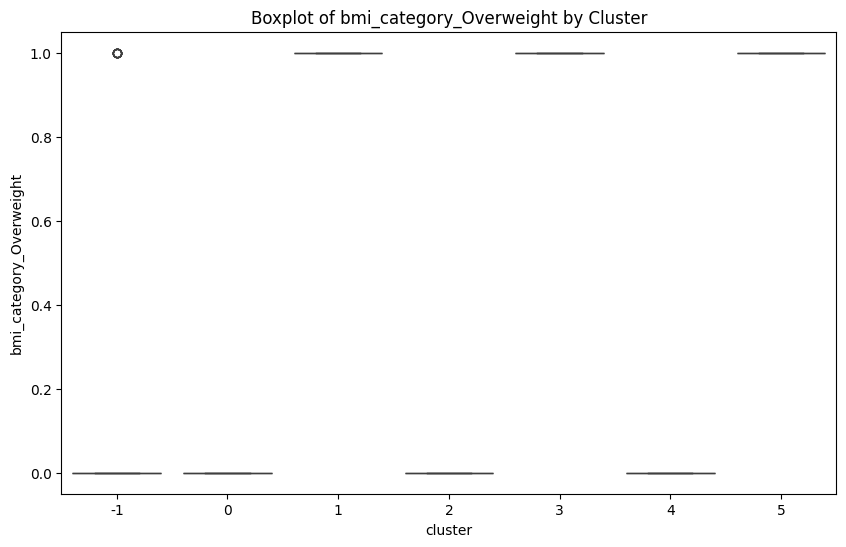

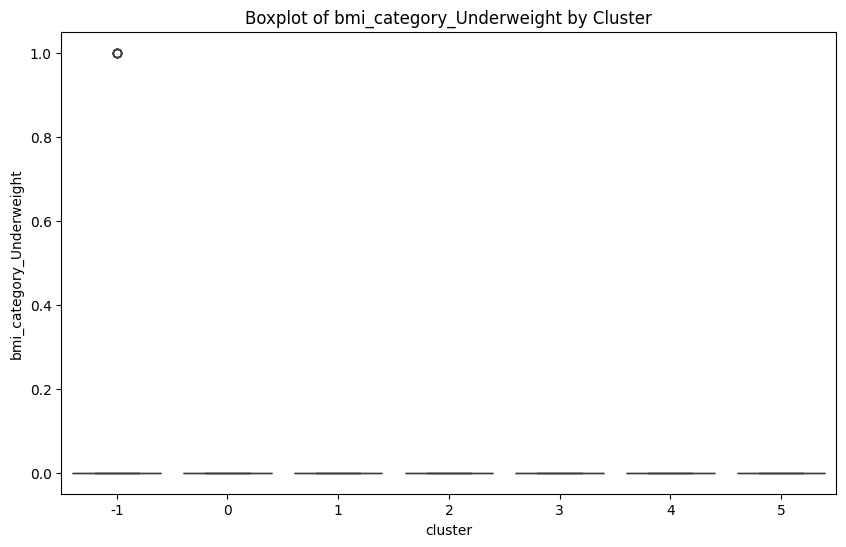

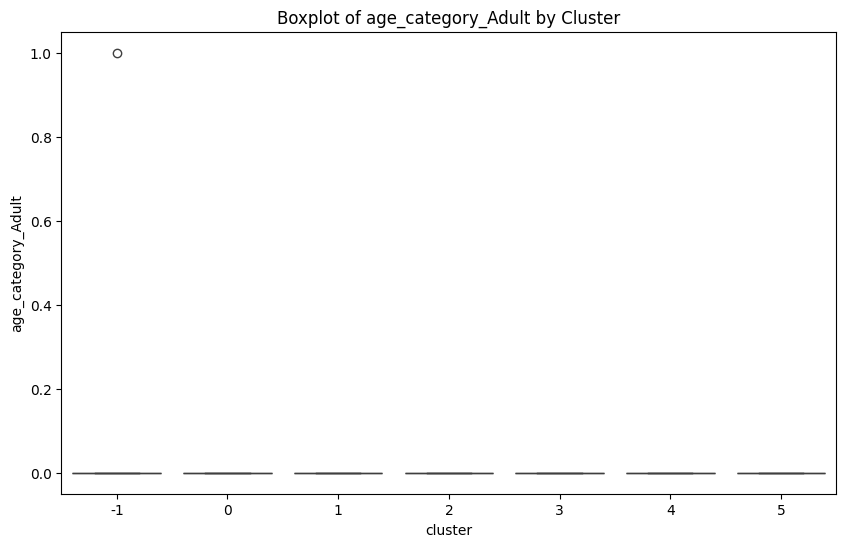

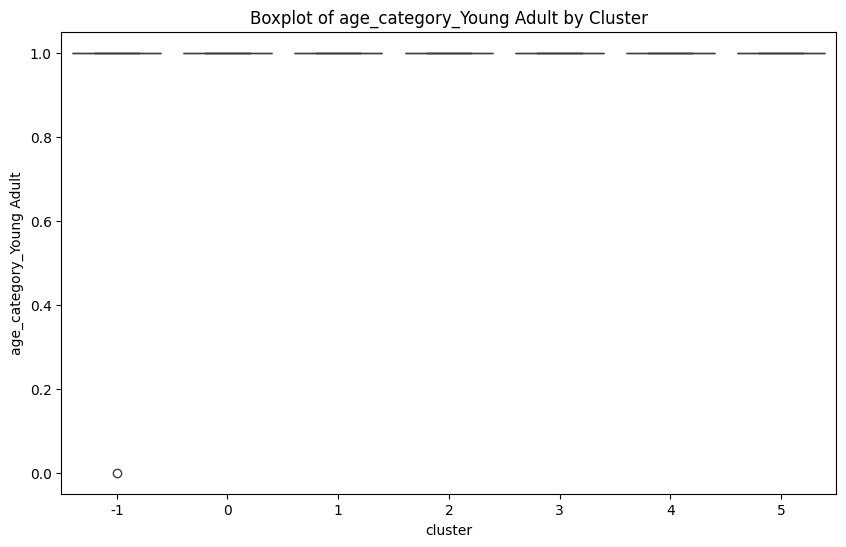

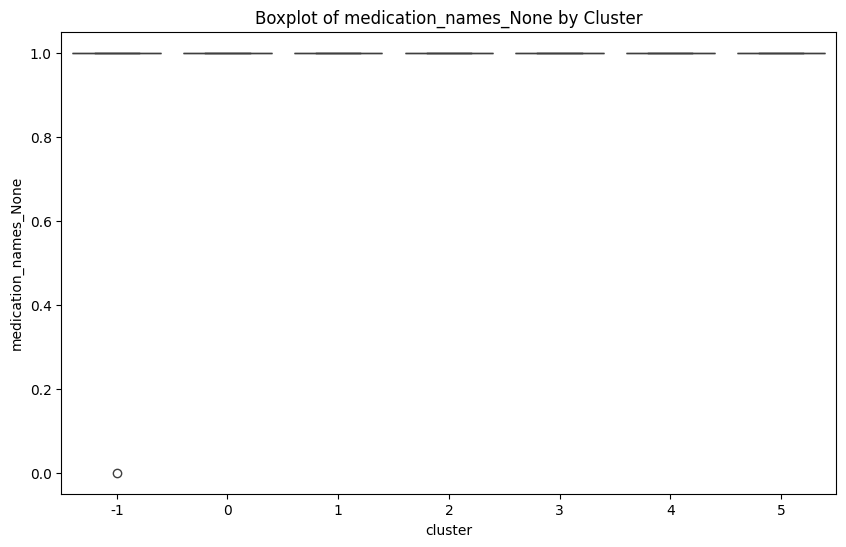

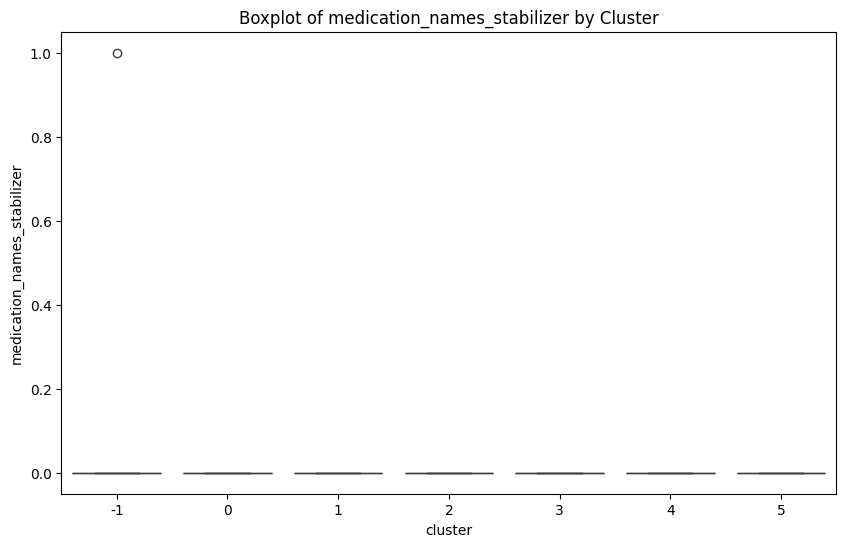

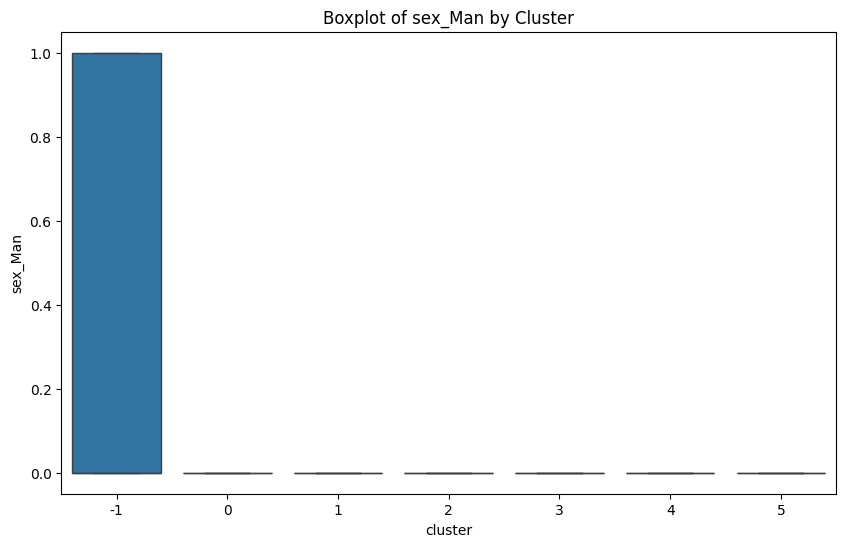

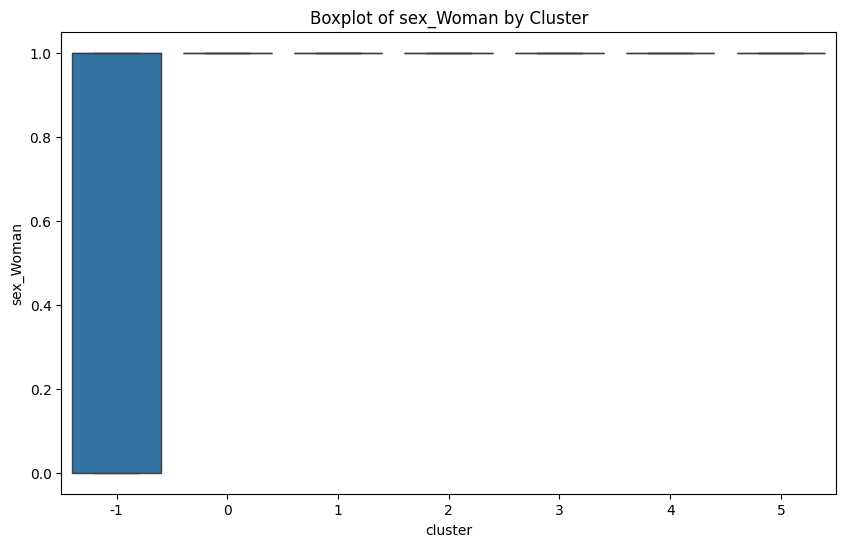

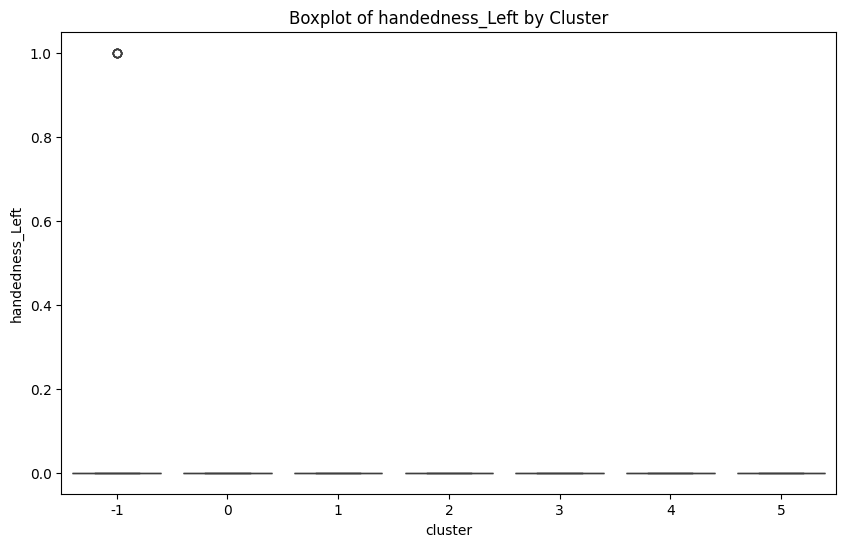

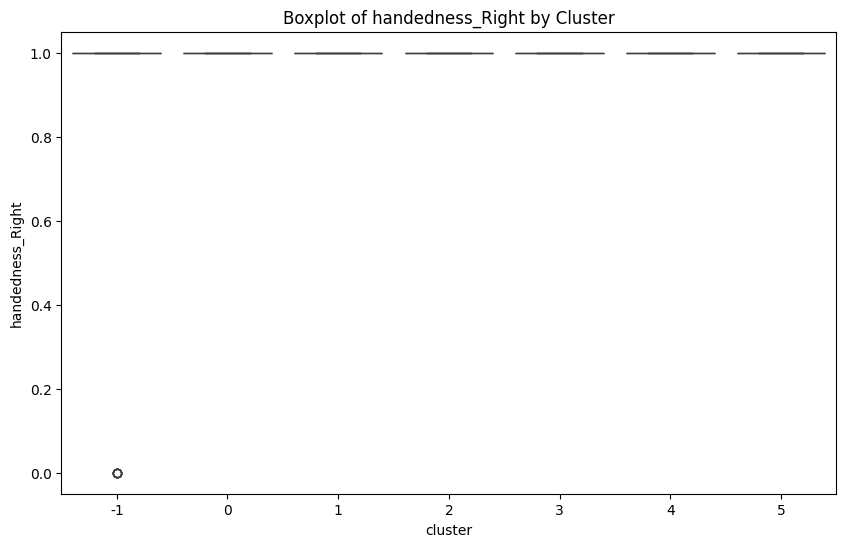

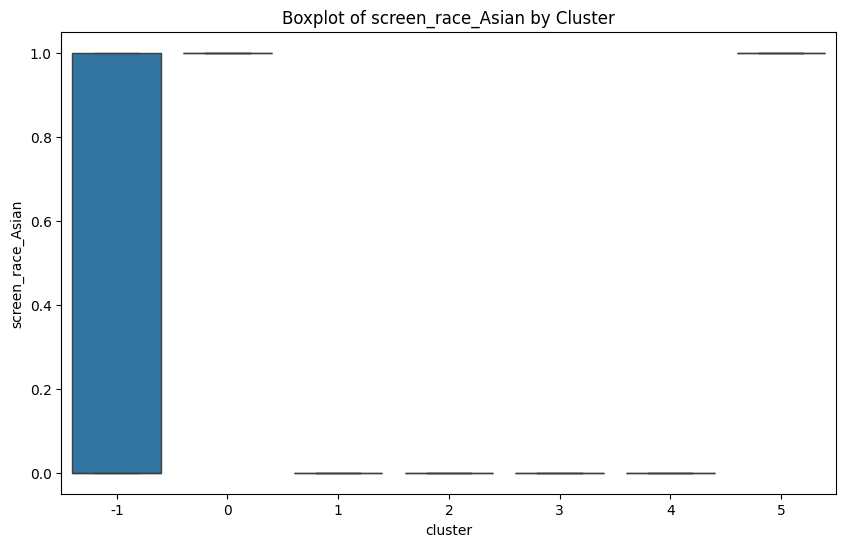

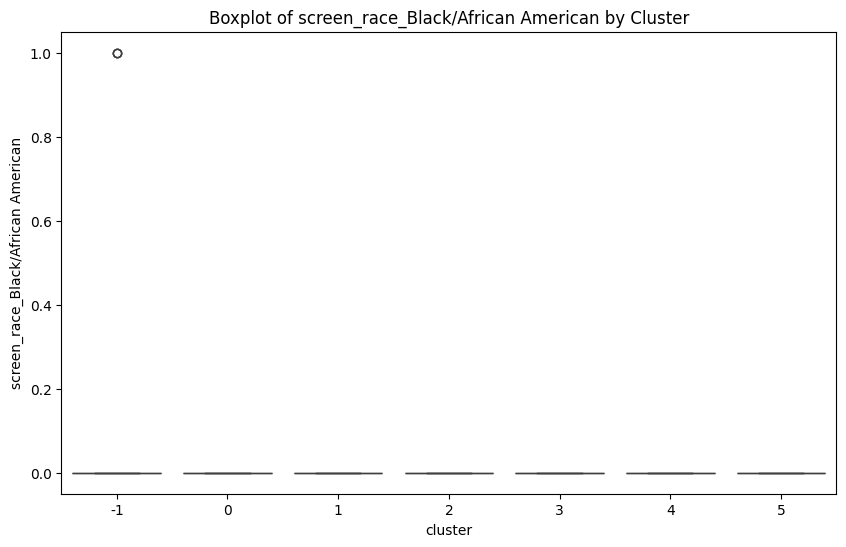

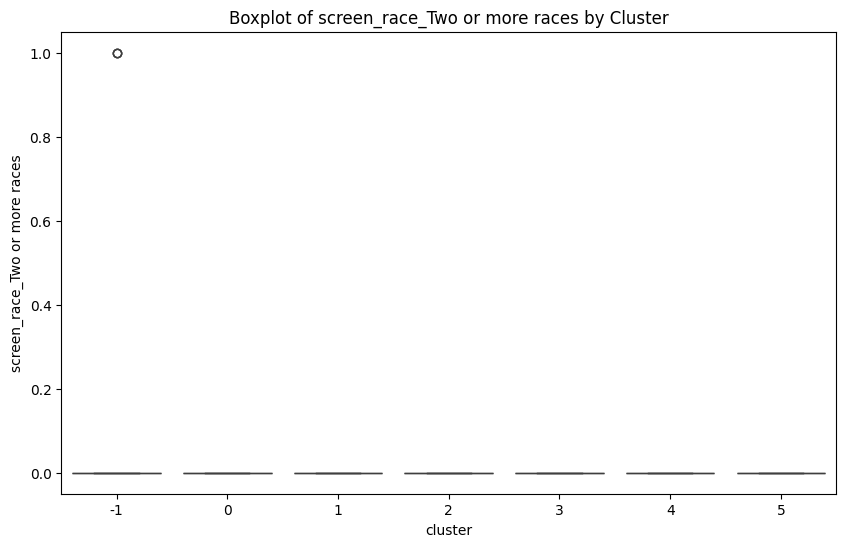

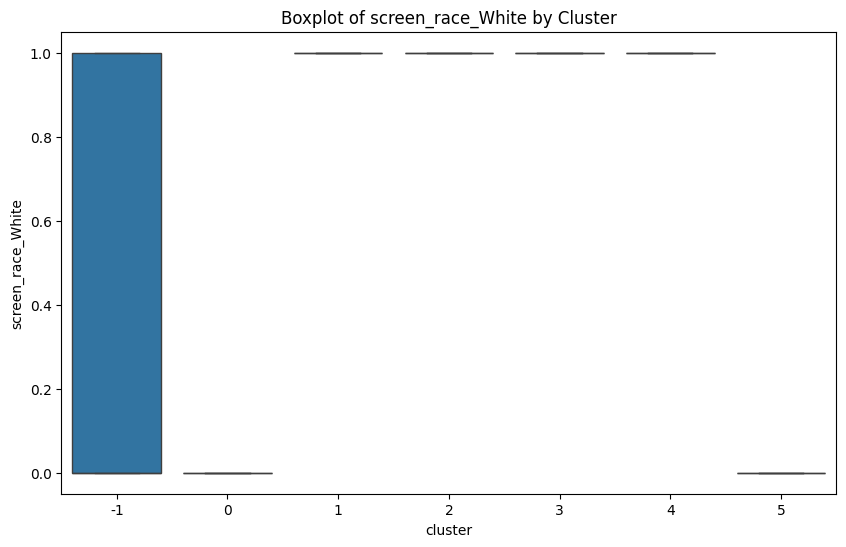

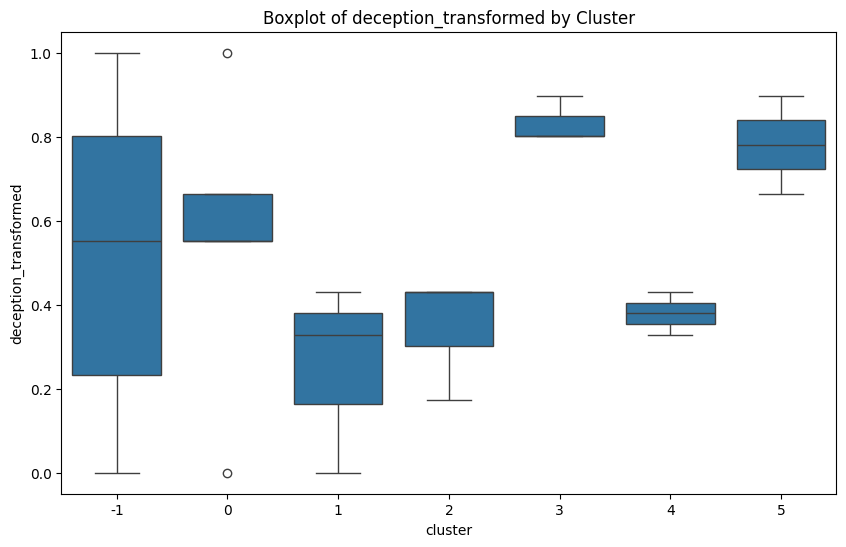

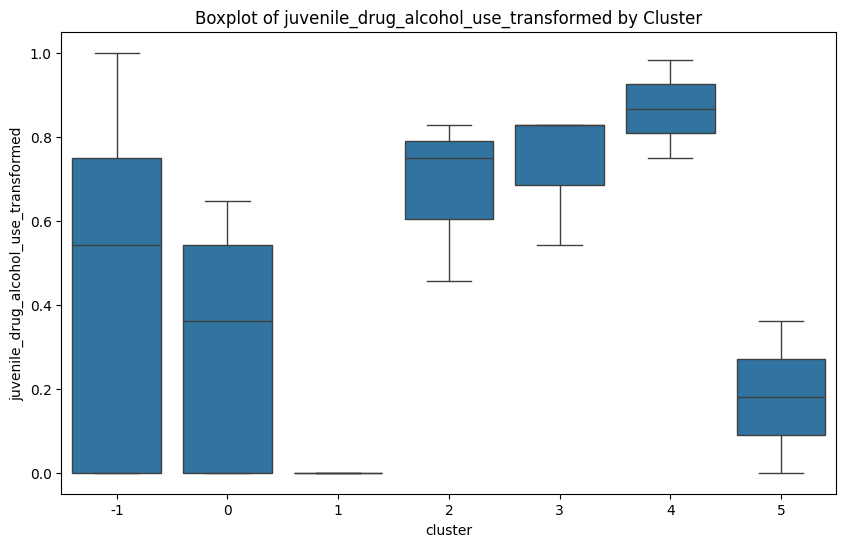

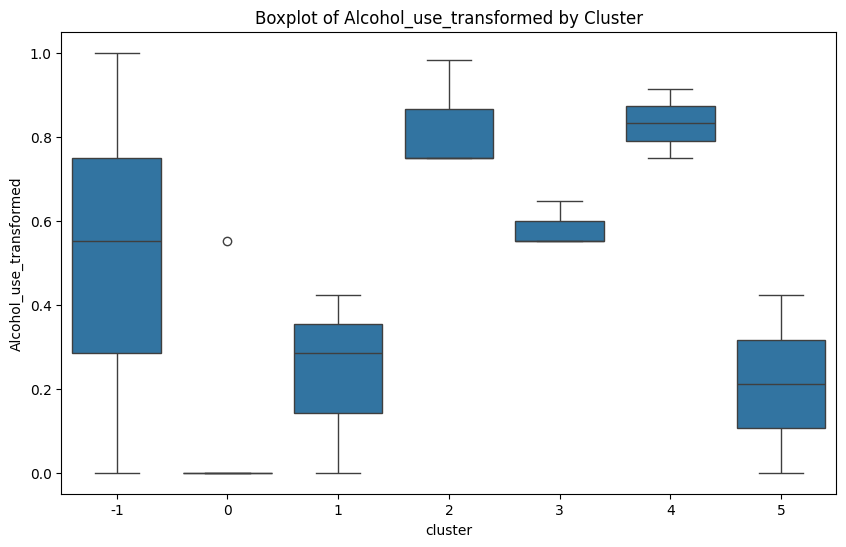

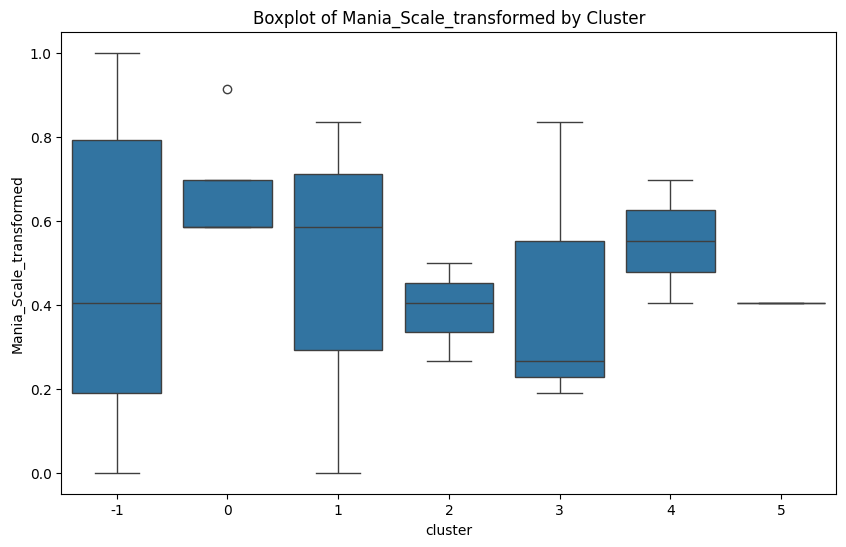

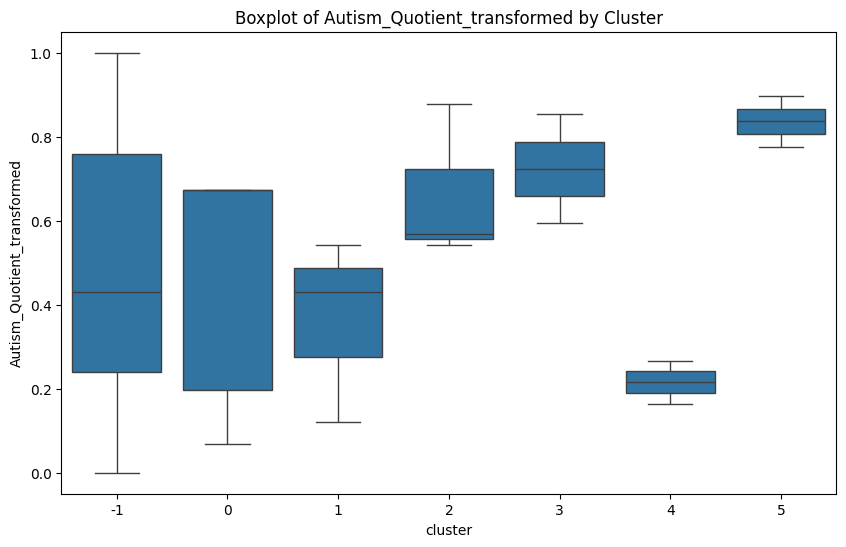

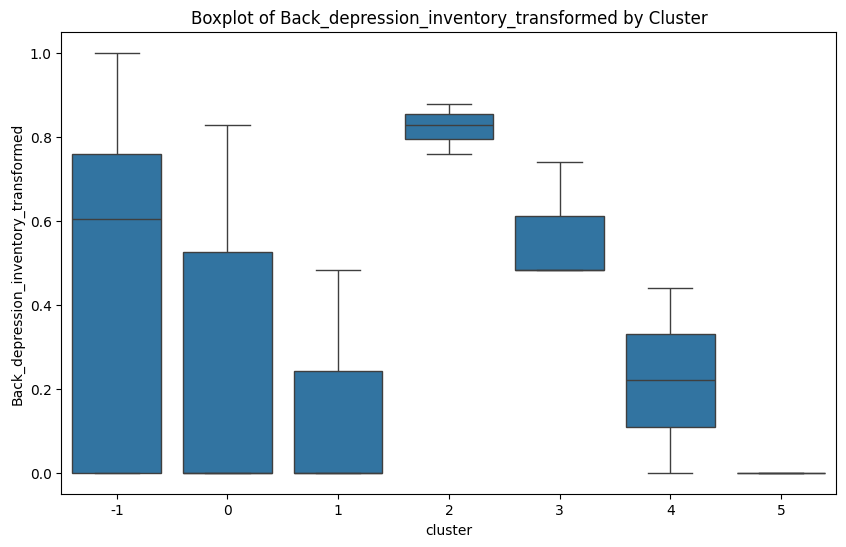

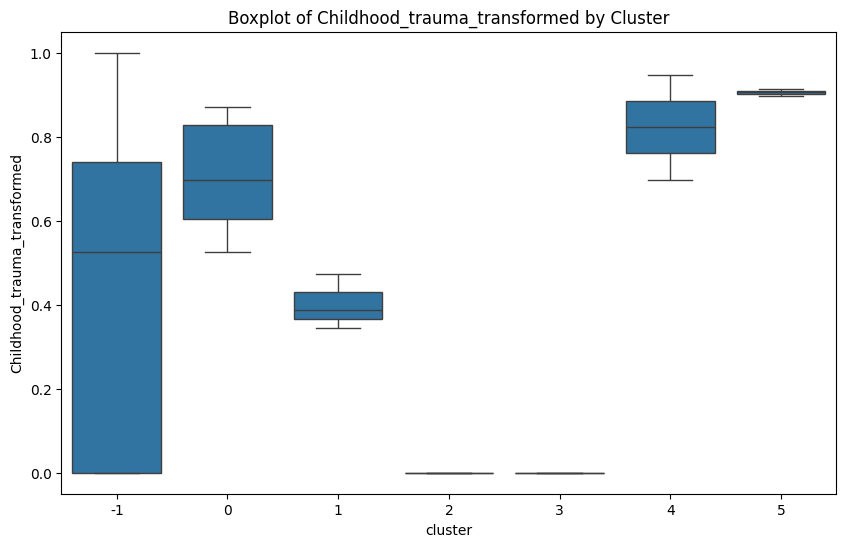

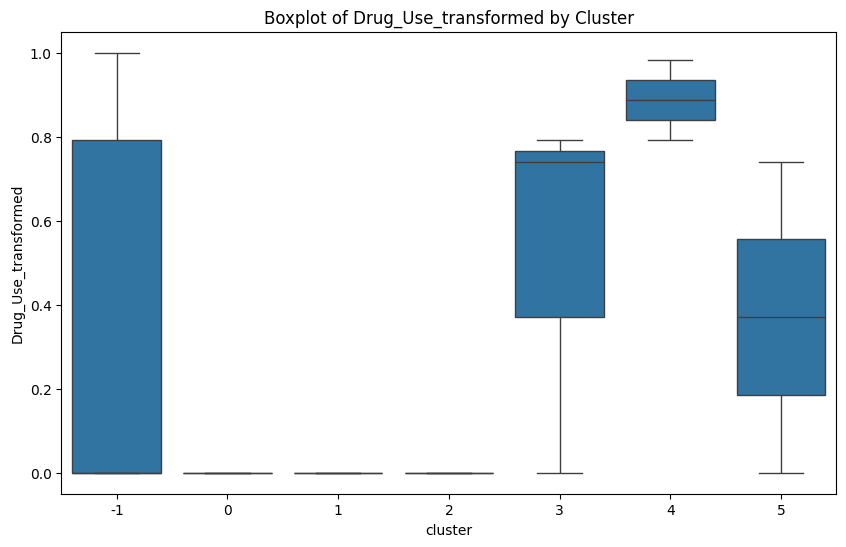

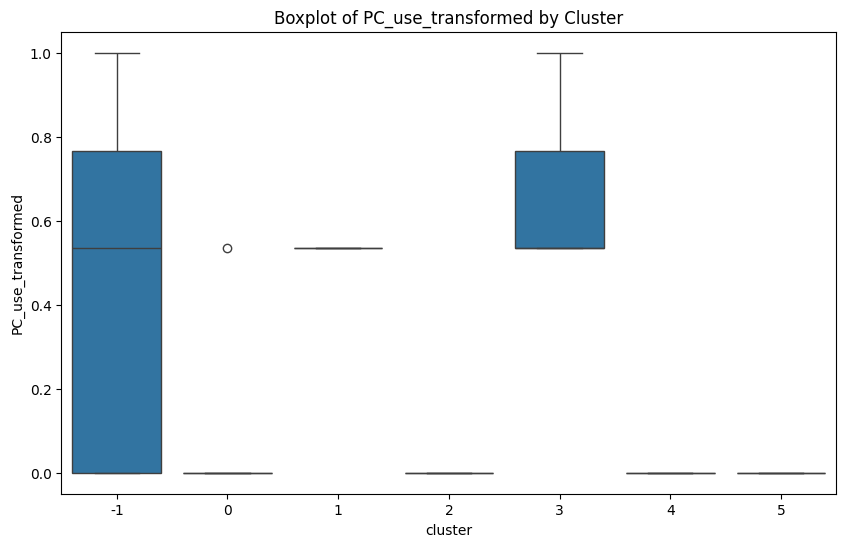

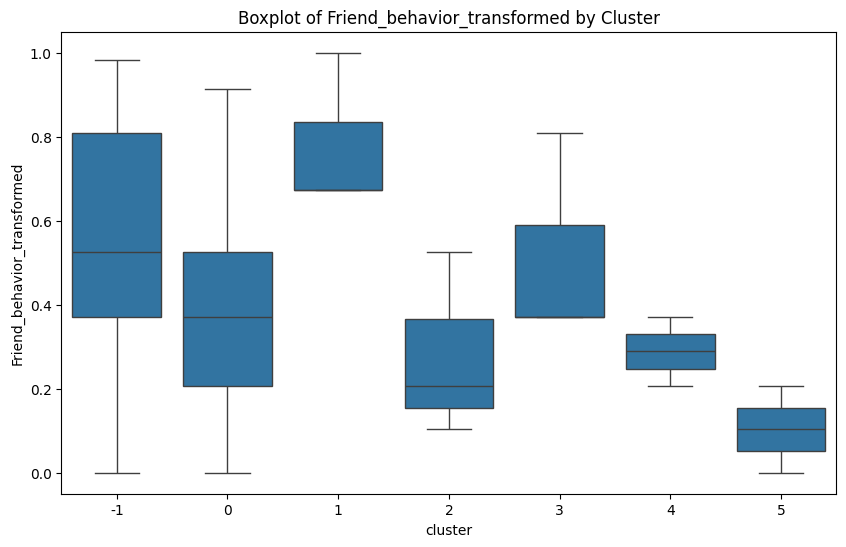

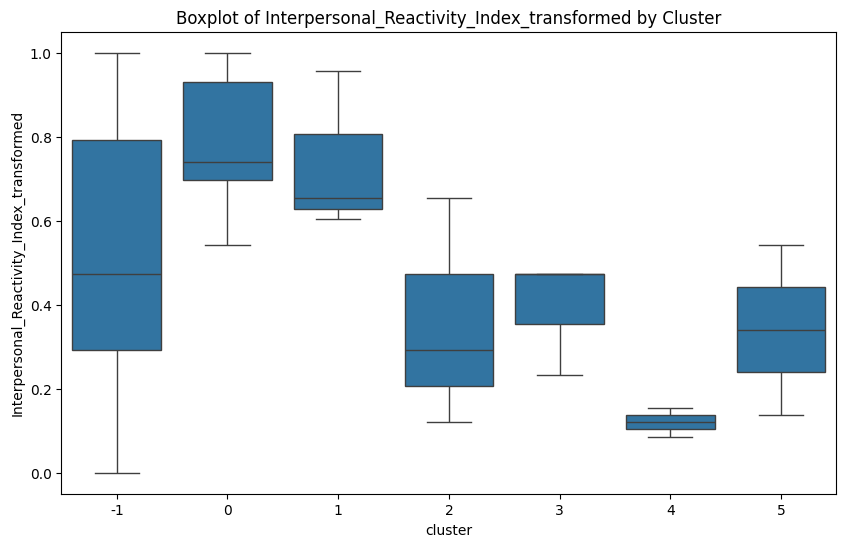

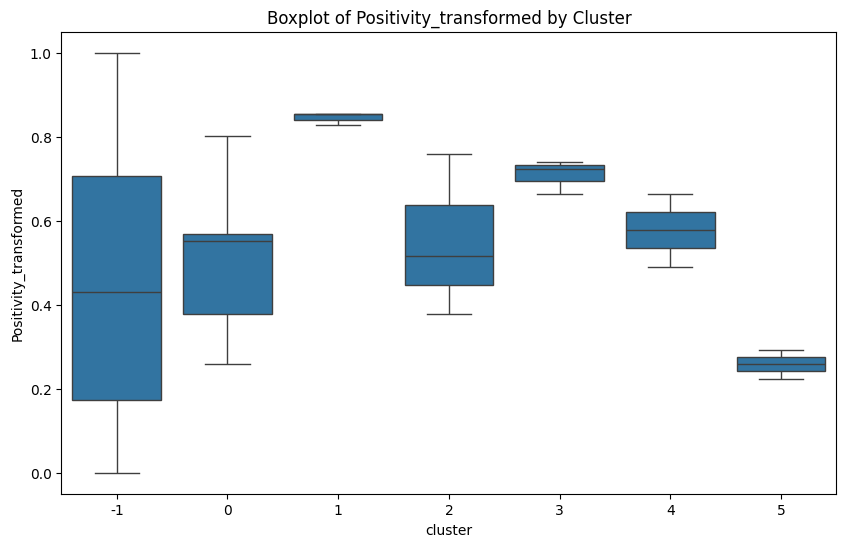

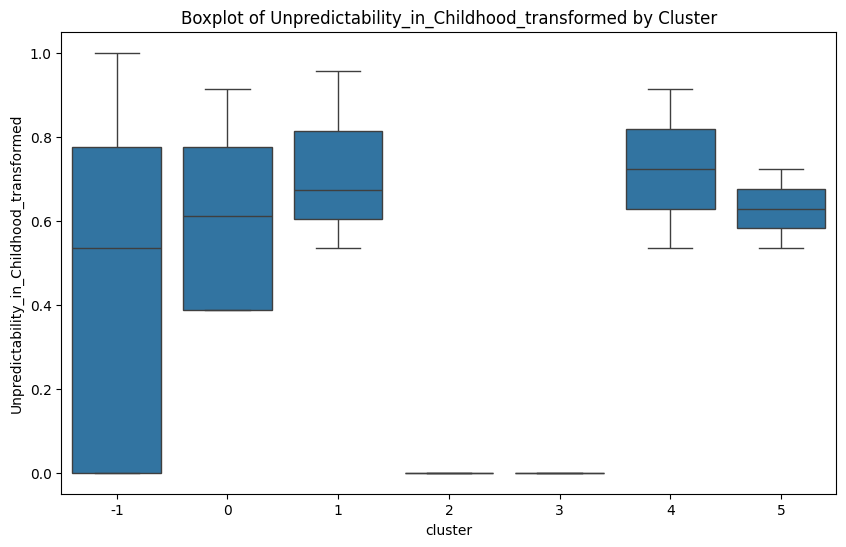

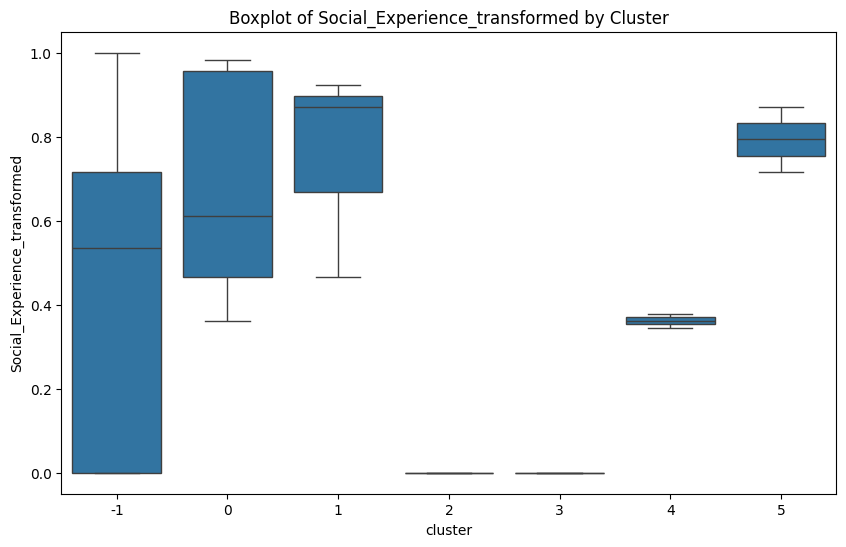

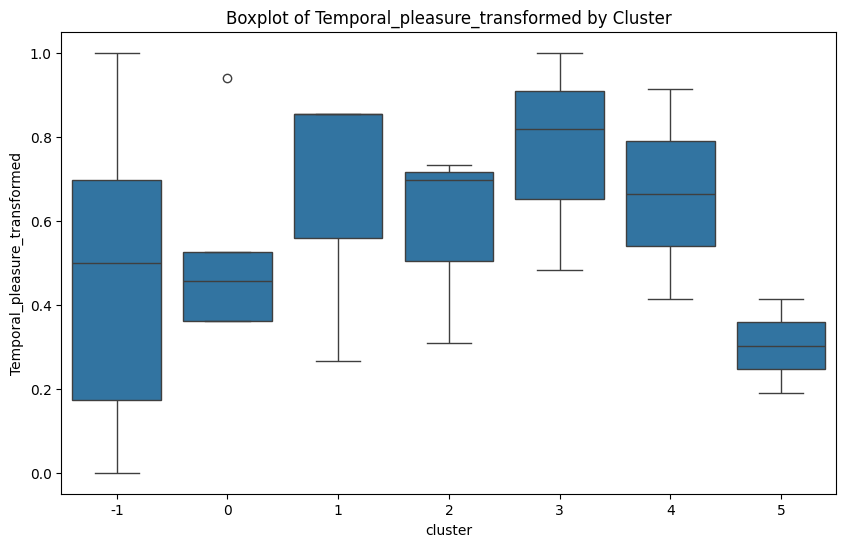

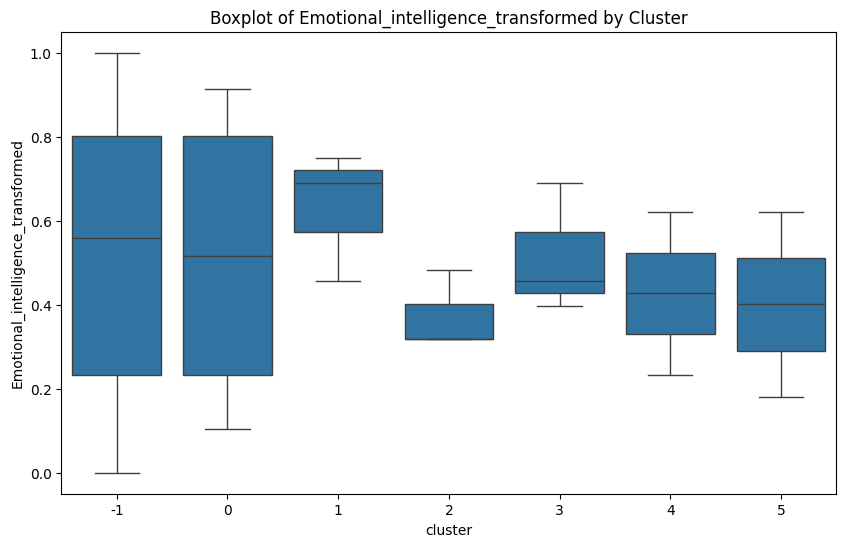

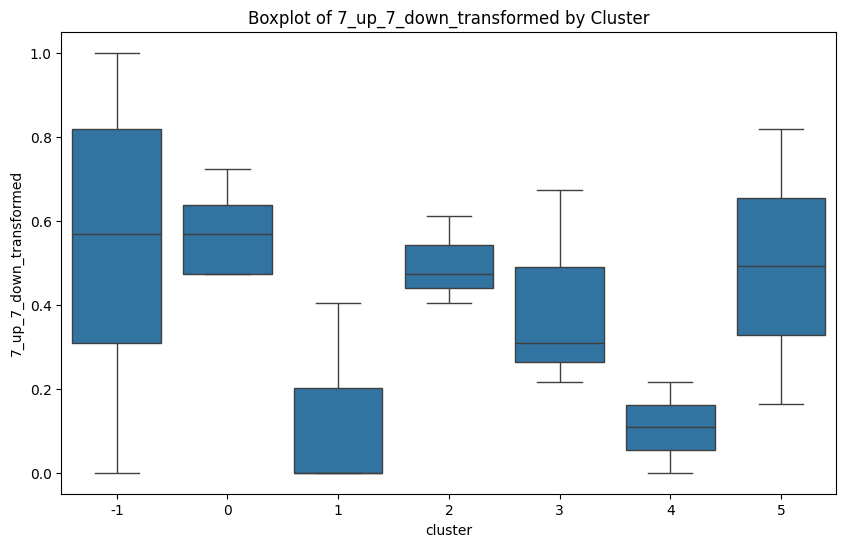

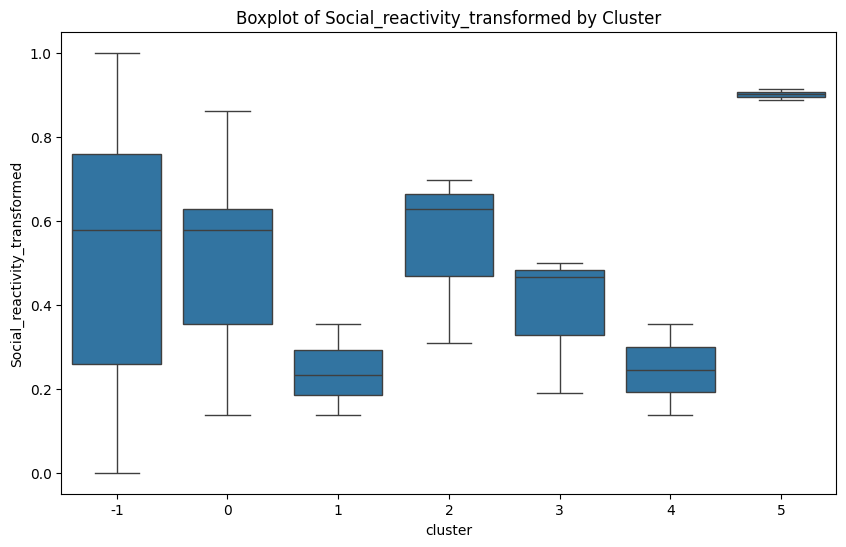

In [16]:
# Create a box plot for each feature within each cluster
for col in features.columns[:-1]:  # Exclude the cluster label column
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=col, data=features)
    plt.title(f'Boxplot of {col} by Cluster')
    plt.show()

##### Well, it's a good start but indicates results are not totally trustworthy

#### What we want to know : how are the clusters placed ?

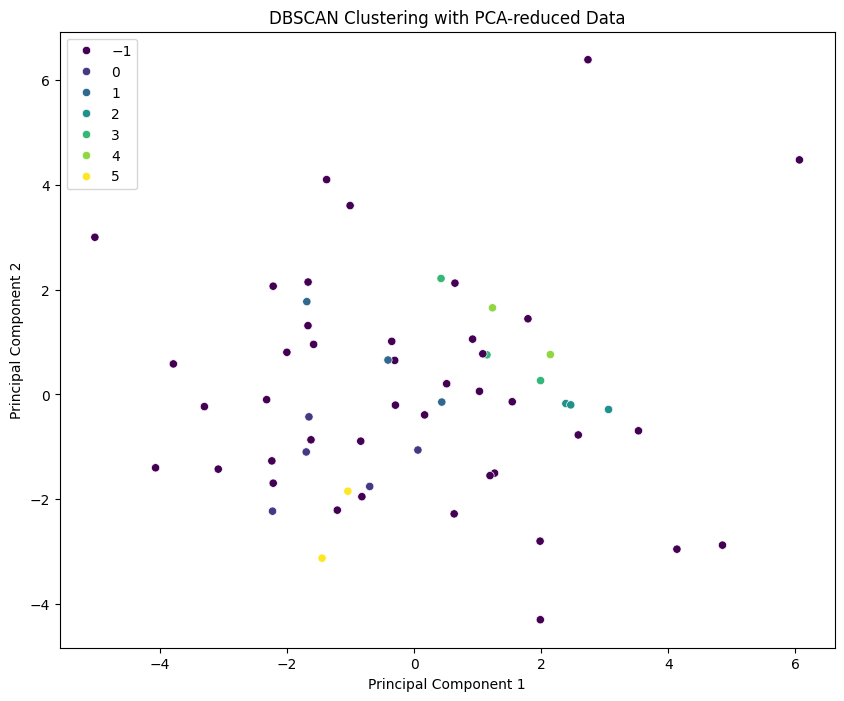

In [17]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])

# Add the cluster labels to this DataFrame
pca_df['cluster'] = labels

# Plot the PCA-transformed features for each DBSCAN cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(x='principal_component_1', y='principal_component_2', hue='cluster', data=pca_df, palette='viridis')
plt.title('DBSCAN Clustering with PCA-reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

##### Let's remove -1 values, as they are not correlated with anything

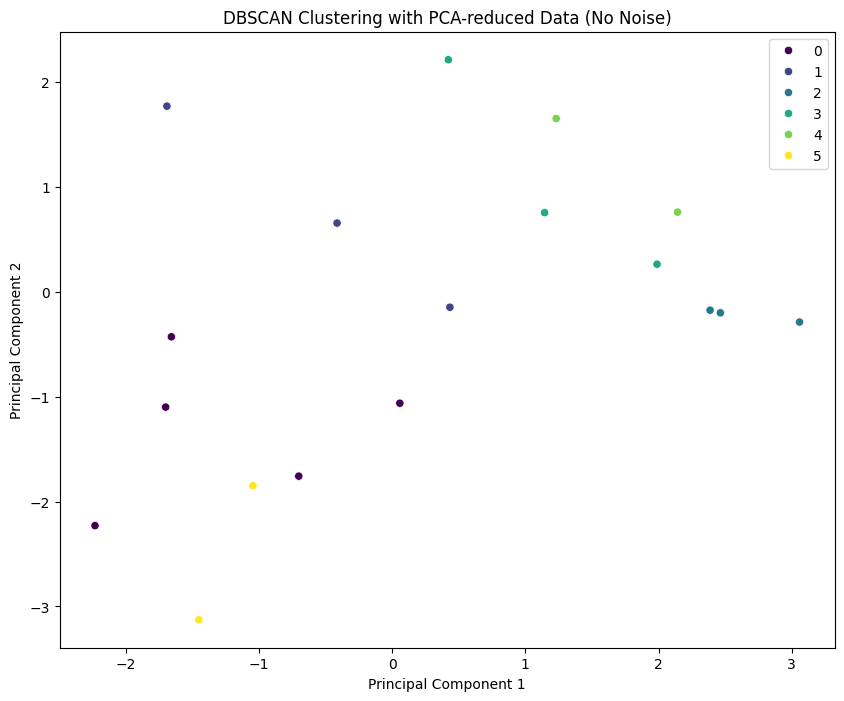

In [18]:
# Filter out the noise points
pca_df_no_noise = pca_df[pca_df['cluster'] != -1]

# Plot the PCA-transformed features for each DBSCAN cluster, excluding noise
plt.figure(figsize=(10, 8))
sns.scatterplot(x='principal_component_1', y='principal_component_2', hue='cluster', data=pca_df_no_noise, palette='viridis', legend='full')
plt.title('DBSCAN Clustering with PCA-reduced Data (No Noise)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

##### Which participants are the great winners ?

In [19]:
# Assuming 'features' is your original DataFrame that includes all data and 'labels' are the DBSCAN labels

# Step 1: Add Cluster Labels to Your DataFrame
features['cluster'] = labels

# Step 2: Reset the Index if 'participant_id' was previously set as index
features.reset_index(inplace=True)

# Step 3: Exclude Noise Points
clustered_data = features[features['cluster'] != -1]

# Step 4: Display Participant IDs for Each Cluster
for cluster in sorted(clustered_data['cluster'].unique()):
    cluster_participants = clustered_data[clustered_data['cluster'] == cluster]['participant_id']
    print(f"Cluster {cluster} consists of participant IDs: {cluster_participants.tolist()}")

# Step 5: Select Only Numeric Data for Mean Calculation
# Ensure to exclude 'participant_id' from the numeric calculations if it's included
numeric_cols = clustered_data.select_dtypes(include=[np.number]).drop(columns=['cluster'], errors='ignore')

# Step 6: Calculate Means for Numeric Columns Only
cluster_means = numeric_cols.groupby(clustered_data['cluster']).mean()

# Print the means to check if the operation was successful
print(cluster_means)

# Step 7: Calculate Overall Means for Comparison
overall_means = numeric_cols.mean()

# Step 8: Find Features with the Most Significant Differences from the Overall Means for Each Cluster
distinctive_features = {}
for cluster in cluster_means.index:
    cluster_mean = cluster_means.loc[cluster]
    differences = cluster_mean - overall_means
    distinctive_features[cluster] = differences.abs().sort_values(ascending=False).head()

# Print the distinctive features for each cluster
for cluster, features in distinctive_features.items():
    print(f"Cluster {cluster} distinctive features:")
    print(features)
    print("\n")



Cluster 0 consists of participant IDs: ['sub-1007', 'sub-3122', 'sub-3170', 'sub-3199', 'sub-3223']
Cluster 1 consists of participant IDs: ['sub-1009', 'sub-1012', 'sub-3116']
Cluster 2 consists of participant IDs: ['sub-1015', 'sub-1019', 'sub-1301']
Cluster 3 consists of participant IDs: ['sub-1243', 'sub-1245', 'sub-1249']
Cluster 4 consists of participant IDs: ['sub-3143', 'sub-3176']
Cluster 5 consists of participant IDs: ['sub-3166', 'sub-3175']
         screen_meds_pastmonth  Inhibited  Self_esteem  \
cluster                                                  
0                     0.000000   0.506800     0.376000   
1                     0.666667   0.582000     0.538667   
2                     0.333333   0.441667     0.540000   
3                     0.666667   0.495333     0.700333   
4                     0.500000   0.489500     0.684500   
5                     0.000000   0.361000     0.333500   

         Sensitivity_to_punishment_reward  total_drug_use  \
cluster           

##### Observations : level_0 and index do not bring anything useful, level_0 is a duplicate so it has to be dropped. Healthy_weight is consistent between all categories, so it may be interesting to reassess differences

In [20]:
# Select only numeric columns and exclude non-informative ones
numeric_cols = clustered_data.select_dtypes(include=[np.number]).drop(columns=['level_0', 'index', 'cluster'], errors='ignore')

# Calculate means for numeric columns only, grouped by cluster
cluster_means = numeric_cols.groupby(clustered_data['cluster']).mean()

# Calculate overall mean for comparison
overall_means = numeric_cols.mean()

# Find features with the most significant differences for each cluster
distinctive_features = {}
for cluster in cluster_means.index:
    cluster_mean = cluster_means.loc[cluster]
    differences = cluster_mean - overall_means
    distinctive_features[cluster] = differences.abs().sort_values(ascending=False).head()

# Print the distinctive features for each cluster
for cluster, features in distinctive_features.items():
    print(f"Cluster {cluster} distinctive features:")
    print(features)
    print("\n")

Cluster 0 distinctive features:
screen_race_White              0.611111
screen_race_Asian              0.611111
bmi_category_Healthy Weight    0.444444
bmi_category_Overweight        0.444444
screen_meds_pastmonth          0.333333
dtype: float64


Cluster 1 distinctive features:
bmi_category_Healthy Weight              0.555556
bmi_category_Overweight                  0.555556
juvenile_drug_alcohol_use_transformed    0.437833
screen_race_Asian                        0.388889
screen_race_White                        0.388889
dtype: float64


Cluster 2 distinctive features:
Back_depression_inventory_transformed    0.463667
Childhood_trauma_transformed             0.455000
bmi_category_Healthy Weight              0.444444
bmi_category_Overweight                  0.444444
Social_Experience_transformed            0.441667
dtype: float64


Cluster 3 distinctive features:
bmi_category_Healthy Weight      0.555556
bmi_category_Overweight          0.555556
PC_use_transformed               0.45

#### Observations

##### Cluster 0
Participants in Cluster 0 are characterized by their racial background, with equal prominence of White and Asian participants. They have a balanced distribution between Healthy Weight and Overweight categories, suggesting a diverse body mass index (BMI) among them. Additionally, there's a notable mention of screen_meds_pastmonth, indicating that a third of participants in this cluster might have reported medication use in the past month. We see medication use is not correlated with a proeminant background of trauma or depression, we can assume a cluster with enough resources to afford healthcare, we cannot say well-off or higher.

##### Cluster 1
This cluster also shows a balance between Healthy Weight and Overweight categories, similar to Cluster 0. However, it is distinctive for higher levels of juvenile_drug_alcohol_use_transformed, suggesting past juvenile drug or alcohol use among participants. The racial background is again balanced between White and Asian participants, but with slightly lower values than in Cluster 0, indicating a somewhat more diverse racial composition. It is interesting to see there is no correlation with drug or alcohol abuse through adulthood, suggesting a recreational, social use during teenager years. In fact juvenile drug and alcohol consumption is higher than other clusters with this feature, and disappear at adulthood. It means, the environment is healthy enough (well-off at least), and factors associated with well-off populations: access to universities, parents help, and in turn higher-wage jobs. It's the highest cluster reflecting happiness. This cluster appears to have a higher standard of living than other clusters.

##### Cluster 2
Cluster 2 participants are marked by higher scores in Back_depression_inventory_transformed and Childhood_trauma_transformed, indicating experiences of depression and trauma. Like the previous clusters, there's a balance between Healthy Weight and Overweight. This cluster also shows a notable Social_Experience_transformed feature, suggesting the significant impact of childhood trauma, then depression, and their major impact in social interactions. Note : those are not correlated with medication use, which means they do not seek medical help to tackle with those aspects. We may note absence of "white" and "asian", which means the prevalence of other races in this category. Theory : lived in less favorized neighborhoods where family violence is at a higher level, trauma are highly correlated to depression through adulthood, impacting their social interactions in a negative way. The price of healthcare may be the reason why this cluster is not correlated with medication use, which should be the case for depression and potential PTSD, meaning they probably couldn't afford seeking professional help during juvenile age, and in the US poverty begets poverty, we can assume this cluster couldn't afford education, meaning low-paid jobs. Psychosocial factors may have played a major role because we see a correlation between altered social interactions, depression, trauma, with no access to healthcare, theoretically for financial reasons, which may in turn have an impact on opportunities in higher education, and as a consequence lower paid jobs.

##### Cluster 3
Participants in this cluster are similarly balanced between Healthy Weight and Overweight. They have higher scores in PC_use_transformed, suggesting significant computer use, along with Childhood_trauma_transformed and Social_Experience_transformed, indicating experiences of childhood trauma. We may theorize that after a juvenile trauma, this cluster was more prone to use a pc (we know some escape their lives through video games for instance). Again, both have strong consequences on social interactions in this cluster.

##### Cluster 4
This cluster is distinguished by higher levels of Drug_Use_transformed and Alcohol_use_transformed, suggesting substance use among participants. The BMI distribution mirrors other clusters with a balance between Healthy Weight and Overweight. Additionally, there's a slightly lower but still significant level of juvenile_drug_alcohol_use_transformed, reinforcing the theme of substance use in this group. In conclusion, this cluster has developed these addictions at a juvenile age, which correlates strongly with substance abuse through adulthood. Theory : this group may live in poorer neighborhoods, where drug is accessible to kids, that lacks the environment cluster 1 has. It may be related to families, the social contacts, school. And in the US neighborhoods concentrate poverty, so from birth, through overcrowded schools with other young peers facing the same difficulties, which impacts the quality of education. This lack of good education and lack of money make universities inaccessible, so they are left with low revenue jobs, the alternative being crime. This cluster also lack caucasian and asian representation, where in cluster 0 access to healthcare is possible, and cluster 1 is in a healthy environment so their juvenile drug use is manageable.

##### Cluster 5
Like Cluster 0, Cluster 5 participants are equally likely to be White or Asian. They have a slightly higher inclination towards being Overweight but also include many in the Healthy Weight category. Childhood_trauma_transformed is a significant feature, indicating experiences of trauma among these participants. Despite their trauma and unlike cluster 4, they do not correlate with juvenile and adult substance abuse, so access is more difficult, which means they live in neighborhoods without rempant drug sale. Still, unlike cluster one where trauma is not a feature, healthcare access is not correlated, we can theorize they are from lower middle-class families. 

#### General Observations
Across all clusters, there's a recurring pattern of balanced BMI categories (Healthy Weight and Overweight), suggesting that BMI alone does not strongly differentiate the clusters. Instead, other behavioral and experiential features such as substance use, racial background, childhood trauma, and computer use provide more distinctive characteristics. Clusters 0 and 5 stand out for their racial composition, Clusters 2 and 3 are notable for psychological and social factors, and Cluster 4 is marked by substance use behaviors.